# Load and check data

In [1]:
import time
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

import gensim
import nltk

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics, model_selection, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, ClassifierMixin

from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import SpatialDropout1D, Bidirectional
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence, text
from keras.utils import np_utils

import xgboost as xgb

Using TensorFlow backend.
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load in the train and test datasets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

full_data = [train, test]

train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
# Prepare the id and label for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train['author'].map(author_mapping_dict)
id_train = train['id'].values
id_test = test['id'].values

In [4]:
# Explore the dataset 
print("Number of rows in train dataset {}".format(train.shape[0]))
print("Number of rows in test dataset {}".format(test.shape[0]))
print("No duplicates in train data") if train.shape[0] == train.text.unique().__len__() else print("Oops")
print("No duplicates in test data") if test.shape[0] == test.text.unique().__len__() else print("Oops")
print("Unique author is data {}".format(train.author.unique()))
print("Number of nulls in the train is {} and text is {}".format(train.isnull().sum().sum(), test.isnull().sum().sum()))

Number of rows in train dataset 19579
Number of rows in test dataset 8392
No duplicates in train data
No duplicates in test data
Unique author is data ['EAP' 'HPL' 'MWS']
Number of nulls in the train is 0 and text is 0


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


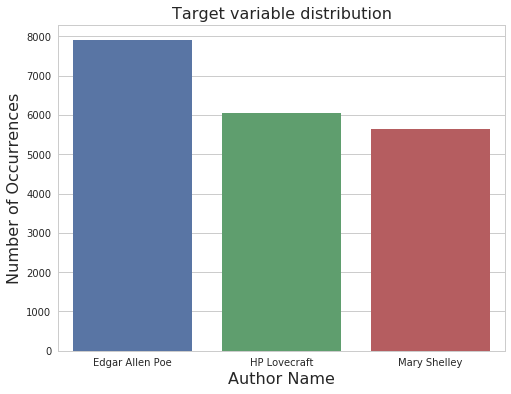

In [5]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
plt.figure(figsize=(8, 6))
plt.title('Target variable distribution', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Author Name', fontsize=16)
sns.barplot(x=train.author.map(z).unique(), y=train.author.value_counts().values)

# Wordclouds

## Visualise each author's work

In [6]:
from imageio import imread
from wordcloud import WordCloud, STOPWORDS

(-0.5, 399.5, 199.5, -0.5)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


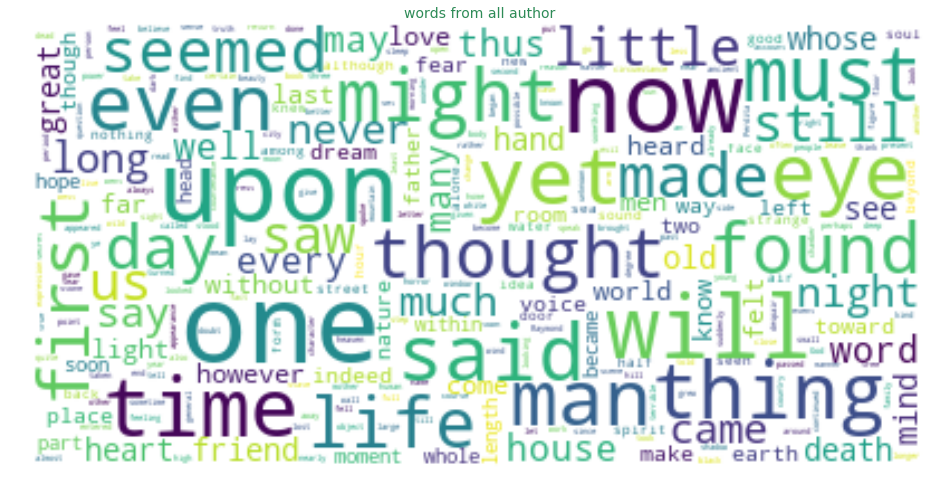

In [7]:
wc = WordCloud(
    background_color="white",
    max_words=5000,
    stopwords=STOPWORDS,
    max_font_size=50)
# generate word cloud
wc.generate(" ".join(train.text.values))

# show
plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from all author", fontsize=14, color='seagreen')
plt.axis("off")

In [8]:
img1 = imread("../images/eap.png")
img2 = imread("../images/mws.png")
img3 = imread("../images/hpl.png")

In [9]:
eap = train[train.author == "EAP"]["text"].values
mws = train[train.author == "MWS"]["text"].values
hpl = train[train.author == "HPL"]["text"].values

(-0.5, 639.5, 390.5, -0.5)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


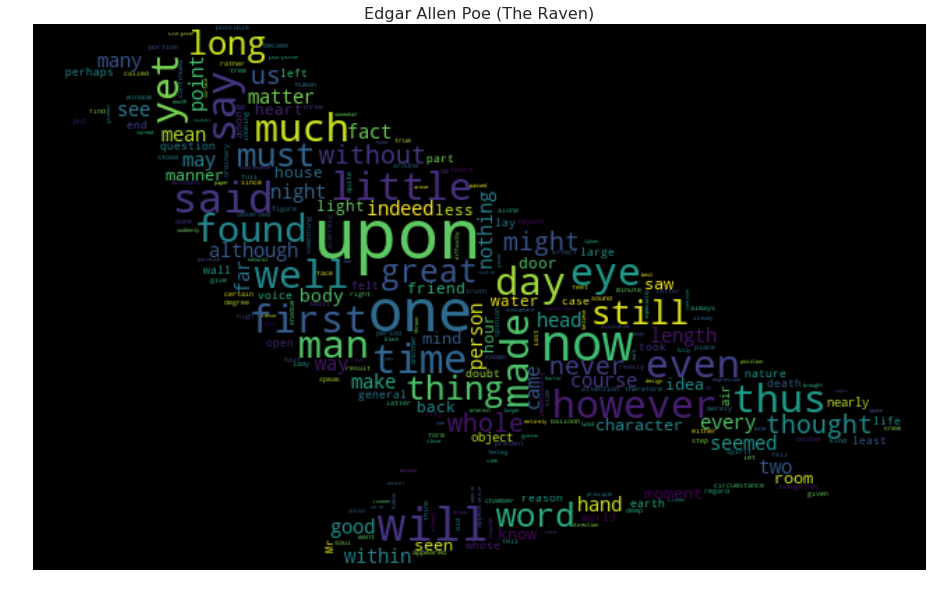

In [10]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img1,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(eap))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Edgar Allen Poe (The Raven)", fontsize=16)
plt.axis("off")

(-0.5, 639.5, 589.5, -0.5)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


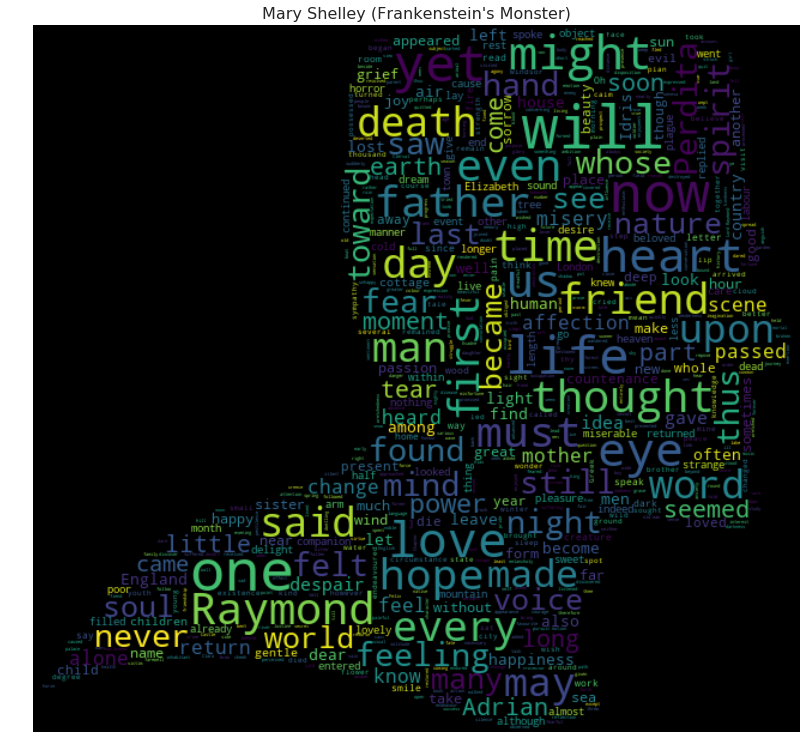

In [11]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img2,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(mws))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize=16)
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


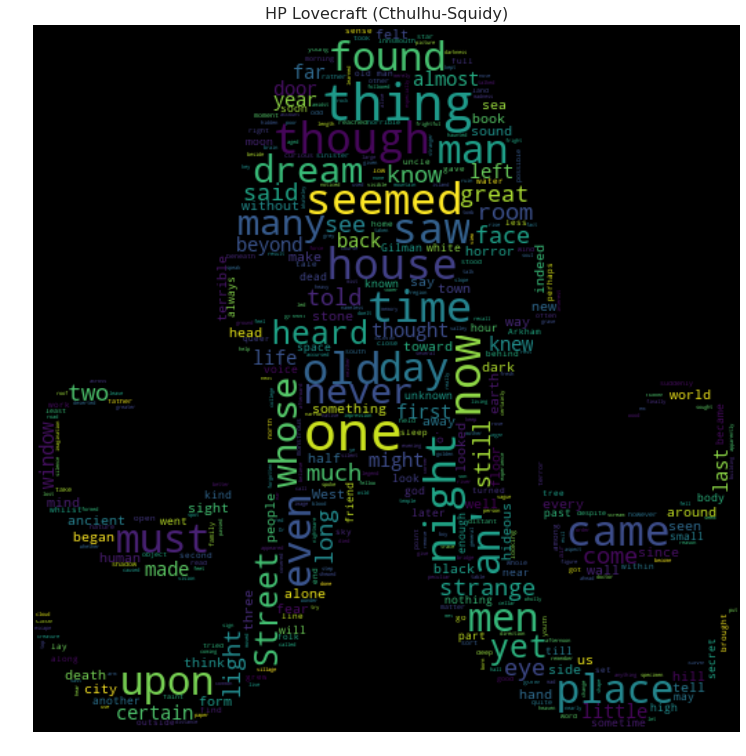

In [12]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img3,
    stopwords=STOPWORDS,
    max_font_size=40)
wc.generate(" ".join(hpl))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=16)
plt.axis('off')

# Natural Language Processing

## Tokenization

In [13]:
# Storing the first text element as a string
first_text = train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [14]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [16]:
first_text_list_cleaned = [
    word for word in first_text_list if word.lower() not in stopwords
]
print(first_text_list_cleaned)
print("=" * 90)
print("Length of original list: {} words\n"
      "Length of list after stopwords removal: {} words".format(
          len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming and Lemmatization

In [17]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
The stemmed form of leaves is: leav


In [18]:
lemm =  nltk.stem.WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("ascertaining")))

The lemmatized form of leaves is: leaf
The lemmatized form of leaves is: ascertaining


## Vectorizing Raw Text

In [19]:
# Defining our sentence
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try CountVectorizer
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [20]:
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try  TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[ 0.63009934  0.44832087  0.          0.44832087  0.44832087]
 [ 0.          0.44832087  0.63009934  0.44832087  0.44832087]]


# Feature Engineering

## Text based features

In [21]:
import string


def word_count(raw):
    return len(raw['text'].split())


def char_count(raw):
    return len(raw['text'])


def word_len_mean(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return np.mean([len(w) for w in text_list])


def unique_word_count(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len(list(set(text_list)))


def stopwords_count(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    return len([w for w in text_list if w in stopwords])


def punctuations_count(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    return len([w for w in text_list if w in string.punctuation])


def word_upper_count(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.isupper()])


def word_title_count(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.istitle()])


def unique_word_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    unique_word_count = len(list(set(text_list)))
    word_count = len(text_list)
    return unique_word_count / word_count


def stopwords_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    stopwords_count = len([w for w in text_list if w in stopwords])
    word_count = len(text_list)
    return stopwords_count / word_count


def punctuations_fraction(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    punctuation_count = len([w for w in text_list if w in string.punctuation])
    char_count = len(text)
    return punctuation_count / char_count


def word_upper_fraction(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    word_upper_count = len([w for w in text_list if w.isupper()])
    word_count = len(text_list)
    return word_upper_count / word_count


def word_title_fraction(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    word_title_count = len([w for w in text_list if w.istitle()])
    word_count = len(text_list)
    return word_title_count / word_count


def noun_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    noun_count = len(
        [w for w in pos_list if w[1] in ('NN', 'NNP', 'NNPS', 'NNS')])
    word_count = len(text_list)
    return noun_count / word_count


def adj_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    adj_count = len([w for w in pos_list if w[1] in ('JJ', 'JJR', 'JJS')])
    word_count = len(text_list)
    return adj_count / word_count


def verbs_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    verbs_count = len([
        w for w in pos_list
        if w[1] in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')
    ])
    word_count = len(text_list)
    return verbs_count / word_count

In [22]:
for dataset in full_data:
    dataset['word_count'] = dataset.apply(lambda raw: word_count(raw), axis=1)
    dataset['char_count'] = dataset.apply(lambda raw: char_count(raw), axis=1)
    dataset['word_len_mean'] = dataset.apply(lambda raw: word_len_mean(raw), axis=1)
    
    dataset['unique_word_count'] = dataset.apply(lambda raw: unique_word_count(raw), axis=1)
    dataset['stopwords_count'] = dataset.apply(lambda raw: stopwords_count(raw), axis=1)
    dataset['punctuations_count'] = dataset.apply(lambda raw: punctuations_count(raw), axis=1)
    dataset['word_upper_count'] = dataset.apply(lambda raw: word_upper_count(raw), axis=1)
    dataset['word_title_count'] = dataset.apply(lambda raw: word_title_count(raw), axis=1)
    
    dataset['unique_word_fraction'] = dataset.apply(lambda raw: unique_word_fraction(raw), axis=1)
    dataset['stopwords_fraction'] = dataset.apply(lambda raw: stopwords_fraction(raw), axis=1)
    dataset['punctuations_fraction'] = dataset.apply(lambda raw: punctuations_fraction(raw), axis=1)
    dataset['word_upper_fraction'] = dataset.apply(lambda raw: word_upper_fraction(raw), axis=1)
    dataset['word_title_fraction'] = dataset.apply(lambda raw: word_title_fraction(raw), axis=1)
    
    dataset['noun_fraction'] = dataset.apply(lambda raw: noun_fraction(raw), axis=1)
    dataset['adj_fraction'] = dataset.apply(lambda raw: adj_fraction(raw), axis=1)
    dataset['verbs_fraction'] = dataset.apply(lambda raw: verbs_fraction(raw), axis=1)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


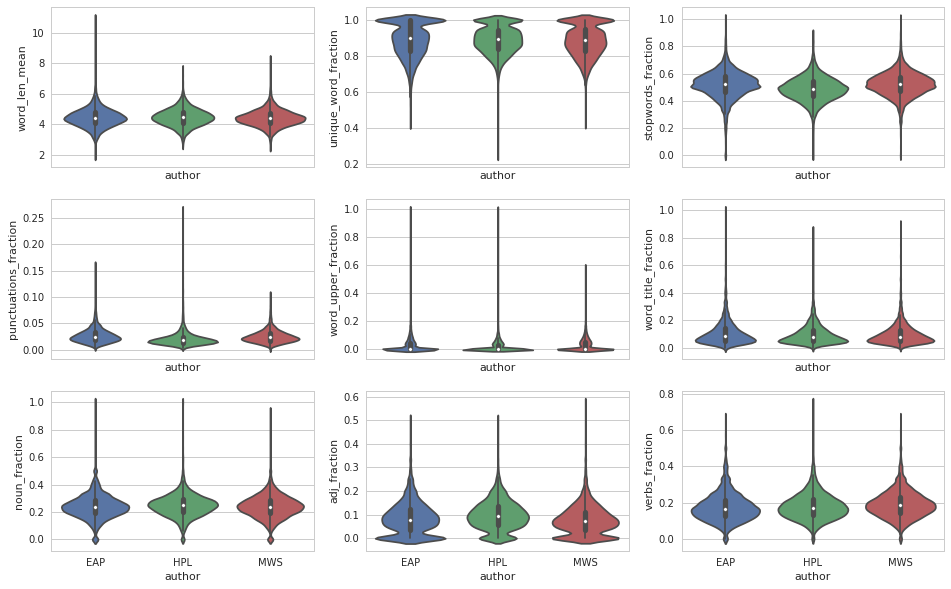

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=(16, 10))
sns.violinplot(x='author', y='word_len_mean', data=train, ax=ax[0, 0])
sns.violinplot(x='author', y='unique_word_fraction', data=train, ax=ax[0, 1])
sns.violinplot(x='author', y='stopwords_fraction', data=train, ax=ax[0, 2])

sns.violinplot(x='author', y='punctuations_fraction', data=train, ax=ax[1, 0])
sns.violinplot(x='author', y='word_upper_fraction', data=train, ax=ax[1, 1])
sns.violinplot(x='author', y='word_title_fraction', data=train, ax=ax[1, 2])

sns.violinplot(x='author', y='noun_fraction', data=train, ax=ax[2, 0])
sns.violinplot(x='author', y='adj_fraction', data=train, ax=ax[2, 1])
sns.violinplot(x='author', y='verbs_fraction', data=train, ax=ax[2, 2])

## word Count and TFIDF features

In [24]:
lemm = nltk.stem.WordNetLemmatizer()


class LemmCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))


class LemmTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmTfidfVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [25]:
# word vectorizer
start = time.time()
ctv = LemmCountVectorizer(
    stop_words='english', token_pattern=r'\w{1,}', ngram_range=(1, 3))
ctv.fit(list(train.text.values) + list(test.text.values))
ctw_train = ctv.transform(train.text.values)
ctw_test = ctv.transform(test.text.values)
end = time.time()
print("Time is {}.".format(end - start))

start = time.time()
tfv = LemmTfidfVectorizer(
    min_df=3,
    strip_accents='unicode',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 3),
    sublinear_tf=1,
    stop_words='english')
tfv.fit(list(train.text.values) + list(test.text.values))
tfw_train = tfv.transform(train.text.values)
tfw_test = tfv.transform(test.text.values)
end = time.time()
print("Time is {}.".format(end - start))

Time is 19.26928448677063.
Time is 19.37001061439514.


## char Count and TFIDF features

In [26]:
# char vectorizer
start = time.time()
ctcv = CountVectorizer(
    ngram_range=(1, 7), analyzer='char', stop_words='english')
ctcv.fit(list(train.text.values) + list(test.text.values))
ctc_train = ctcv.transform(train.text.values)
ctc_test = ctcv.transform(test.text.values)
end = time.time()
print("Time is {}.".format(end - start))

start = time.time()
tfcv = TfidfVectorizer(
    ngram_range=(1, 7), analyzer='char', stop_words='english')
tfcv.fit(list(train.text.values) + list(test.text.values))
tfc_train = tfcv.transform(train.text.values)
tfc_test = tfcv.transform(test.text.values)
end = time.time()
print("Time is {}.".format(end - start))

Time is 58.973618268966675.
Time is 61.43267488479614.


## SVD and Scale on word TFIDF features

In [27]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
start = time.time()
n_comp = 120
svd = TruncatedSVD(n_components=n_comp, algorithm='arpack', random_state=2017)

svdw_train = svd.fit_transform(tfw_train)
svdw_test = svd.transform(tfw_test)
end = time.time()
print("Time is {}.".format(end - start))

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
start = time.time()
scl = StandardScaler()
scl_svdw_train = scl.fit_transform(svdw_train)
scl_svdw_test = scl.transform(svdw_test)

columns = ['scl_svdw_' + str(i) for i in range(n_comp)]
train = pd.concat([train, pd.DataFrame(scl_svdw_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(scl_svdw_test, index=test.index, columns=columns)], axis=1)

end = time.time()
print("Time is {}.".format(end - start))

Time is 3.295114755630493.
Time is 0.06926202774047852.


In [28]:
#xtrain, xval, ytrain, yval = model_selection.train_test_split(
#    scl_svdw_train, y_train, test_size=0.2, random_state=2017)
#dtrain = xgb.DMatrix(xtrain, label=ytrain)
#dval = xgb.DMatrix(xval, label=yval)
#dtest = xgb.DMatrix(scl_svdw_test)
#watchlist = [(dtrain, 'train'), (dval, 'valid')]
#
#model_3 = xgb.train(
#    xgb_param,
#    dtrain,
#    2000,
#    watchlist,
#    early_stopping_rounds=50,
#    maximize=False,
#    verbose_eval=40)

## SVD and Scale on char TFIDF features

In [29]:
start = time.time()
n_comp = 120
svd = TruncatedSVD(n_components=n_comp, algorithm='arpack', random_state=2017)

svdc_train = svd.fit_transform(tfc_train)
svdc_test = svd.transform(tfc_test)
end = time.time()
print("Time is {}.".format(end - start))

start = time.time()
scl = StandardScaler()
scl_svdc_train = scl.fit_transform(svdc_train)
scl_svdc_test = scl.transform(svdc_test)

columns = ['scl_svdc_' + str(i) for i in range(n_comp)]
train = pd.concat([train, pd.DataFrame(scl_svdc_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(scl_svdc_test, index=test.index, columns=columns)], axis=1)

end = time.time()
print("Time is {}.".format(end - start))

Time is 83.64505791664124.
Time is 0.09560298919677734.


In [30]:
# Try to adjust the parameters of the TruncatedSVD n_components
#n_splits = 5
#kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
#cv_scores = []
#pred_full_test = 0
#pred_train = np.zeros([train.shape[0], 3])
#
#for idx_dev, idx_val in kf.split(svd_train):
#    x_dev, x_val = svd_train[idx_dev], svd_train[idx_val]
#    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
#    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, svd_test)
#    pred_full_test = pred_full_test + pred_y_test
#    pred_train[idx_val, :] = pred_y_val
#    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
#    break
#pred_full_test = pred_full_test / float(n_splits)
#print("Mean cv score : {}".format(np.mean(cv_scores)))

## Markov event based features

In [31]:
class Dictogram(dict):
    def __init__(self, iterable=None):
        """Initialize this histogram as a new dict; update with given items"""
        super(Dictogram, self).__init__()
        self.types = 0  # the number of distinct item types in this histogram
        self.tokens = 0  # the total count of all item tokens in this histogram
        if iterable:
            self.update(iterable)

    def update(self, iterable):
        """Update this histogram with the items in the given iterable"""
        for item in iterable:
            if item in self:
                self[item] += 1
                self.tokens += 1
            else:
                self[item] = 1
                self.types += 1
                self.tokens += 1

    def count(self, item):
        """Return the count of the given item in this histogram, or 0"""
        if item in self:
            return self[item]
        return 0

    def return_random_word(self):
        # Another way:  Should test: random.choice(histogram.keys())
        random_key = random.sample(self, 1)
        return random_key[0]

    def return_weighted_random_word(self):
        # Step 1: Generate random number between 0 and total count - 1
        random_int = random.randint(0, self.tokens - 1)
        index = 0
        list_of_keys = self.keys()
        # print 'the random index is:', random_int
        for i in range(0, self.types):
            index += self[list_of_keys[i]]
            # print index
            if (index > random_int):
                # print list_of_keys[i]
                return list_of_keys[i]

In [32]:
# markov chain based features, order words memory
def make_higher_order_markov_model(data, order):
    markov_model = dict()

    for char_list in data:
        for i in range(len(char_list) - order):
            # Create the window
            window = tuple(char_list[i:i + order])
            # Add to the dictionary
            if window in markov_model:
                # We have to just append to the existing Dictogram
                markov_model[window].update([char_list[i + order]])
            else:
                markov_model[window] = Dictogram([char_list[i + order]])
    return markov_model


def make_tuples(char_list, order):
    """function to make tuples of order size given a char_list and order"""
    list_of_tuple = []
    chars = []
    for i in range(len(char_list) - order):
        window = tuple(char_list[i:i + order])
        list_of_tuple.append(window)
        chars.append(char_list[i + order])
    return (list_of_tuple, chars)


def sent_to_prob(raw, author, order):
    """function to get the markov model to give prob of a author given a char_list """
    char_list = raw['splited_char_list']
    list_of_tuples, chars = make_tuples(char_list, order)

    p = 0

    # convert to log so we can sum probabilities instead of multiply
    if author == 'eap':
        for i in range(len(chars)):
            try:
                p_char = eap_MM[list_of_tuples[i]][chars[i]]
                p_chars = sum([x for x in eap_MM[list_of_tuples[i]].values()])
            except:
                p_char = 1
                p_chars = 1
            p += np.log(p_char / p_chars)
    elif author == 'hpl':
        for i in range(len(chars)):
            try:
                p_char = hpl_MM[list_of_tuples[i]][chars[i]]
                p_chars = sum([x for x in hpl_MM[list_of_tuples[i]].values()])
            except:
                p_char = 1
                p_chars = 1
            p += np.log(p_char / p_chars)
    elif author == 'mws':
        for i in range(len(chars)):
            try:
                p_char = mws_MM[list_of_tuples[i]][chars[i]]
                p_chars = sum([x for x in mws_MM[list_of_tuples[i]].values()])
            except:
                p_char = 1
                p_chars = 1
            p += np.log(p_char / p_chars)

    return p


def text_to_char_list(raw):
    text = raw['text'].lower()
    char_list = [c for c in text]

    return char_list

In [33]:
full_data = [train, test]

for dataset in full_data:
    dataset['splited_char_list'] = dataset.apply(lambda raw: text_to_char_list(raw), axis=1)
    
raw_eap = train[train.author == 'EAP']['splited_char_list'].values
raw_hpl = train[train.author == 'HPL']['splited_char_list'].values
raw_mws = train[train.author == 'MWS']['splited_char_list'].values

for order in range(3, 5):
    # build markov model
    start = time.time()
    eap_MM = make_higher_order_markov_model(raw_eap, order)
    hpl_MM = make_higher_order_markov_model(raw_hpl, order)
    mws_MM = make_higher_order_markov_model(raw_mws, order)
    end = time.time()
    print("Time is {}.".format(end - start))

    # create markov features
    start = time.time()
    for dataset in full_data:
        dataset['EAP_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'eap', order), axis=1)
        dataset['HPL_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'hpl', order), axis=1)
        dataset['MWS_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'mws', order), axis=1)

    end = time.time()
    print("Time is {}.".format(end - start))
    
for dataset in full_data:
    del dataset['splited_char_list']

Time is 5.804877996444702.
Time is 85.0647964477539.
Time is 6.277011394500732.
Time is 80.57870173454285.


In [34]:
for order in range(3, 5):
    select_elements = ['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]
    tmp_train = train[select_elements]
    tmp_test = test[select_elements]
    
    train = train.drop(select_elements, axis=1)
    test = test.drop(select_elements, axis=1)

    # Min-max normalization (row)
    tmp_train = tmp_train.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
    tmp_test = tmp_test.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
    
    train = pd.concat([train, tmp_train], axis=1)
    test = pd.concat([test, tmp_test], axis=1)

In [35]:
markov_train = pd.DataFrame()
for order in range(3, 5):
    markov_train = pd.concat(
    [
        markov_train, train[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
    ],
    axis=1)
markov_train.head()

,EAP_markov_3,HPL_markov_3,MWS_markov_3,EAP_markov_4,HPL_markov_4,MWS_markov_4
0,1.000000,0.608336,0.000000,1.000000,0.376305,0.000000
1,0.000000,1.000000,0.284183,0.075062,0.000000,1.000000
2,0.923098,1.000000,0.000000,0.000000,1.000000,0.962391
3,0.000000,0.296056,1.000000,0.000000,0.519331,1.000000
4,1.000000,0.227594,0.000000,0.986159,0.000000,1.000000


In [36]:
#print(eap_MM[('n', 'o', 'm', 'e')])
#print(sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))
#print(eap_MM[('n', 'o', 'm', 'e')]['r'])
#print(eap_MM[('n', 'o', 'm', 'e')]['r'] / sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))

## Sentence vector features

### word2vec

In [37]:
# Load Google's pre-trained Word2Vec model.
word2vec = gensim.models.KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin', binary=True)

In [38]:
stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')


def sent2vec(sentence):
    text_list = tokenizer.tokenize(sentence.lower())
    text_list = [w for w in text_list if w not in stopwords]
    text_list = [w for w in text_list if w.isalpha()]
    
    M = []
    for w in text_list:
        try:
            M.append(word2vec[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [39]:
start = time.time()

train_text = train.text.values
test_text = test.text.values
sentvec_train = [sent2vec(x) for x in train_text]
sentvec_test = [sent2vec(x) for x in test_text]

sve_train = np.array(sentvec_train)
sve_test = np.array(sentvec_test)

print(sve_train.shape, sve_test.shape)

end = time.time()
print("Time is {}.".format(end - start))

(19579, 300) (8392, 300)
Time is 4.894219398498535.


In [40]:
sve_train[:10]

array([[ 0.02904126,  0.08354078, -0.00709849, ..., -0.06769396,
         0.01069763, -0.06179029],
       [ 0.10052475,  0.01727861,  0.04257155, ..., -0.09593672,
        -0.00849961,  0.00739672],
       [ 0.037039  ,  0.08301822,  0.00543684, ..., -0.01286392,
        -0.02826099, -0.06427049],
       ..., 
       [ 0.02051976,  0.0325538 ,  0.07779089, ..., -0.11057117,
        -0.02270914, -0.03007753],
       [ 0.03529366,  0.03349921,  0.04096162, ..., -0.05455082,
         0.04626312, -0.03061373],
       [ 0.07788838, -0.04411064,  0.04182817, ..., -0.07330013,
         0.01751836,  0.03442355]])

In [25]:
np.save('../model/sve_train', sve_train)
np.save('../model/sve_test', sve_test)
#sve_train = np.load('../model/sve_train.npy')
#sve_test = np.load('../model/sve_test.npy')

### glove

In [ ]:
glove_file = '../glove/glove.840B.300d.txt'


# load the GloVe vectors in a dictionary:
def loadGloveEmbeddings(glove_file):
    embeddings_index = {}
    with open(glove_file) as f:
        for line in tqdm(f):
            values = line.split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index


#loadGloveEmbeddings(glove_file)

## Sentiment Analysis based features

# Deep Learning

## Word2Vec preprocess

In [62]:
stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def text_process(sentence):
    text_list = tokenizer.tokenize(sentence.lower())
    #text_list = [w for w in text_list if w not in stopwords]
    text_list = [w for w in text_list if w.isalpha()]
    txt = " ".join([w for w in text_list])
    
    return txt
    
train_text = [text_process(x) for x in train.text.values]
test_text = [text_process(x) for x in test.text.values]

train_text = np.array(train_text)
test_text = np.array(test_text)

train_text.shape

print(train_text[0])
print(test_text[0])

this process however afforded me no means of ascertaining the dimensions of my dungeon as i might make its circuit and return to the point whence i set out without being aware of the fact so perfectly uniform seemed the wall
still as i urged our leaving ireland with such inquietude and impatience my father thought it best to yield


In [63]:
y_train_enc = np_utils.to_categorical(y_train)

xtrain, xvalid, ytrain, yvalid = model_selection.train_test_split(
    train_text, y_train_enc, test_size=0.2, random_state=2017)
xtest = test_text

In [64]:
# using keras tokenizer here
token = Tokenizer()
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid) + list(xtest))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
xtest_seq = token.texts_to_sequences(xtest)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [65]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    try:
        embedding_vector = word2vec[word]
    except:
        continue
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 28327/28327 [00:00<00:00, 102428.24it/s]


In [65]:
print(xtrain[0])
print(xtrain_seq[0])
print(xtrain_pad[0])
print(word_index['you'])
print(word2vec['you'])
print(embedding_matrix[33])

You had mentioned Geneva as the name of your native town, and towards this place I resolved to proceed.
[33, 12, 771, 2208, 16, 1, 253, 2, 78, 715, 328, 3, 314, 26, 149, 5, 597, 4, 1373]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   33   12  771 2208   16    1  253    2   78
  715  328    3  314   26  149    5  597    4 1373]
33
[ 0.20410156  0.01318359  0.07568359  0.28515625 -0.10888672  0.10107422
 -0.02954102  0.0480957  -0.11132812 -0.00326538 -0.09277344 -0.05761719
 -0.12988281 -0.11132812 -0.24707031  0.140625    0.07470703  0.02661133
  0.23632812 -0.06689453  0.02856445  0.09082031  0.19140625 -0.08251953
 -0.02978516  0.11425781 -0.03442383  0.00344849 -0.00102234 -0.05444336
 -0.05615234  0.09033203 -0.03637695 -0.05761719 -0.20898438 -0.02893066
  0.09765625  0.

## Build model

In [21]:
class RnnClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 batch_size=32,
                 epochs=3,
                 dropout=0,
                 rnn_type='gru',
                 hidden_layer=[64, 32]):
        self.batch_size = batch_size
        self.epochs = epochs
        self.dropout = dropout
        self.rnn_type = rnn_type
        self.hidden_layer = hidden_layer

        self._rnn = None
        self._num_classes = None
        self._num_words = None

    def fit(self, X, Y=None):
        assert (Y is not None), "Y is required"
        assert (self.rnn_type in ['gru', 'lstm', 'simple']), "Invalid RNN type"

        # How many different tags do we have?
        #self._num_words = np.max(X) + 1

        # How many classes should we predict?
        #self._num_classes = np.max(Y) + 1

        node_type = None
        if self.rnn_type is 'gru':
            node_type = GRU
        elif self.rnn_type is 'lstm':
            node_type = LSTM
        else:
            node_type = SimpleRNN

        # Transfer the data into a appropiated shape
        X = self._reshape_input(X)

        # Ready for rumble?! Here the actual neural network starts!
        self._rnn = Sequential()
        self._rnn.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=X.shape[1], trainable=False))
        self._rnn.add(SpatialDropout1D(self.dropout))
        
        # Add the hidden layers and their dropout
        for (i, hidden_neurons) in enumerate(self.hidden_layer):
            sequences = i != len(self.hidden_layer) - 1
            self._rnn.add(node_type(hidden_neurons, dropout=self.dropout, recurrent_dropout=self.dropout,
                                    return_sequences=sequences))
                          
        self._rnn.add(Dense(1024))
        self._rnn.add(BatchNormalization())
        self._rnn.add(Activation("relu"))
        self._rnn.add(Dropout(0.8))
                          
        self._rnn.add(Dense(32))
        self._rnn.add(BatchNormalization())
        self._rnn.add(Activation("relu"))
        self._rnn.add(Dropout(0.8))

        # Add the output layer and compile the model
        self._rnn.add(Dense(3, activation='softmax'))
        self._rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self._rnn.summary()

        # Convert the results in the right format and start the training process
        #Y = to_categorical(Y, num_classes=self._num_classes)
        self._rnn.fit(
            X, Y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        return self

    def predict(self, X, y=None):
        if self._rnn is None:
            raise RuntimeError("Fitting required before prediction!")

        # 'Softmax' returns a list of probabilities - just use the highest onw
        return np.argmax(
            self._rnn.predict(
                self._reshape_input(X), batch_size=self.batch_size))

    def score(self, X, y=None):
        assert (y is not None), "Y is required"

        # Evaluate the model on training data
        return self._rnn.evaluate(
            self._reshape_input(X),
            to_categorical(y, num_classes=self._num_classes))[1]

    def _reshape_input(self, X):
        result = np.resize(X, (X.shape[0], X.shape[1], self._num_words))
        for x in range(0, X.shape[0]):
            for y in range(0, X.shape[1]):
                result[x, y] = to_categorical(
                    X[x, y], num_classes=self._num_words)[0]
        return result

In [1]:
#param_grid = {
#    'rnn_type': ['lstm', 'gru'],
#    'hidden_layer': [[], [64], [64, 32]],
#    'epochs': [10, 20],
#    'dropout': [0.6, 0.8]
#}
#
#
#model = GridSearchCV(
#    estimator=RnnClassifier(epochs=10),
#    param_grid=param_grid,
#    scoring='neg_log_loss',
#    verbose=10,
#    n_jobs=-1,
#    iid=True,
#    refit=True,
#    cv=5)
#
#model.fit(xtrain_pad, ytrain)

### LSTM layers based model

In [9]:
model = Sequential()

model.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.8))

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# Fit the model with early stopping callback
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
#model.fit(
#    x=xtrain_pad,
#    y=ytrain,
#    batch_size=256,
#    epochs=100,
#    verbose=1,
#    validation_data=(xvalid_pad, yvalid),
#    callbacks=[earlystop])

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 75s 5ms/step - loss: 1.5872 - acc: 0.4287 - val_loss: 1.0443 - val_acc: 0.5089

In [13]:
## serialize model to JSON
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
## serialize weights to HDF5
#model.save_weights("model.h5")
#print("Saved model to disk")

Loaded model from disk


### GRU layers based model

In [9]:
# GRU with glove embeddings and two dense layers
model2 = Sequential()
model2.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False))
model2.add(SpatialDropout1D(0.3))
model2.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model2.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model2.add(Dense(1024))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(0.8))

model2.add(Dense(32))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(0.8))

model2.add(Dense(3))
model2.add(Activation('softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fit the model with early stopping callback
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
#model2.fit(
#    x=xtrain_pad,
#    y=ytrain,
#    batch_size=256,
#    epochs=100,
#    verbose=1,
#    validation_data=(xvalid_pad, yvalid),
#    callbacks=[earlystop])

Train on 15663 samples, validate on 3916 samples
Epoch 1/100
15663/15663 [==============================] - 26s 2ms/step - loss: 1.6414 - acc: 0.3723 - val_loss: 1.0770 - val_acc: 0.3534

In [15]:
## serialize model to JSON
#model2_json = model2.to_json()
#with open("model2.json", "w") as json_file:
#    json_file.write(model2_json)
## serialize weights to HDF5
#model2.save_weights("model2.h5")
#print("Saved model2 to disk")

Loaded model from disk


# Ensembling & Stacking models

## Helper functions

In [41]:
# Some useful parameters which will come in handy later on
SEED = 2017  # for reproducibility
NFOLDS = 5  # set folds for out-of-fold prediction
nclass = 3  # different classes
kf = model_selection.KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

In [42]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        if seed != -1:
            params['random_state'] = seed
        self.clf = clf(**params)

    def fit(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x_test):
        return self.clf.predict(x_test)

    def predict_proba(self, x_test):
        return self.clf.predict_proba(x_test)

    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_

In [43]:
# Out-of-Fold Predictions
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((x_train.shape[0], nclass))
    oof_test = np.zeros((x_test.shape[0], nclass))
    oof_test_skf = np.empty((NFOLDS, x_test.shape[0], nclass))
    cv_scores = []

    for i, (idx_dev, idx_val) in enumerate(kf.split(x_train)):
        x_dev, x_val = x_train[idx_dev], x_train[idx_val]
        y_dev, y_val = y_train[idx_dev], y_train[idx_val]

        clf.fit(x_dev, y_dev)
        pred_y_val = clf.predict_proba(x_val)
        pred_full_test = clf.predict_proba(x_test)

        oof_train[idx_val, :] = pred_y_val
        oof_test_skf[i, :] = pred_full_test

        cv_scores.append(metrics.log_loss(y_val, pred_y_val))

    print('Mean cv score: {}'.format(np.mean(cv_scores)))
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train, oof_test

In [44]:
# Confusion Matrix
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
xgb_param = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'lambda': 2.0,
    
    'nthread': -1,
    'silent': 1,
    'eval_metric': "mlogloss",
    'objective': 'multi:softprob',
    'num_class': 3
}


def runXGB(x_train, y_train, x_val, y_val, x_test):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, y_val)
    dtest = xgb.DMatrix(x_test)
    watchlist = [(dtrain, 'train'), (dval, 'val')]

    model = xgb.train(
        xgb_param,
        dtrain,
        2000,
        watchlist,
        early_stopping_rounds=50,
        maximize=False,
        verbose_eval=40)
    pred_y_val = model.predict(dval, ntree_limit=model.best_ntree_limit)
    pred_y_test = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    return pred_y_val, pred_y_test, model

## Generating our Base First-Level Models

In [31]:
## Logistic Regression parameters
#lr_params = {'C': 10, 'penalty': 'l2'}
#
## Multinomial Naive Bayes parameters
#mnb_params = {'alpha': 0.1}
#
## Random Forest parameters
#rf_params = {
#    'n_jobs': -1,
#    'max_depth': 6,
#    'max_features': 'auto',  #
#    'min_samples_leaf': 20,  #
#    'n_estimators': 300,  #
#    'verbose': 0,
#    #'warm_start': True
#    'warm_start': False
#}
#
## SGBoost parameters
#xgb_params = {
#    'learning_rate': 0.1,
#    'n_estimators': 1000,
#    'max_depth': 5,
#    'min_child_weight': 1,
#    'gamma': 0,
#    'subsample': 0.8,
#    'colsample_bytree': 0.7,
#    #'lambda': 2.0,
#    'nthread': -1,
#    'silent': 1,
#    #'eval_metric': "mlogloss",
#    'objective': 'multi:softprob',
#    #'num_class': 3
#}

In [33]:
# Create 5 objects that represent our 4 models
#lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
#mnb = SklearnHelper(clf=MultinomialNB, seed=-1, params=mnb_params)
#rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
#xgbc = SklearnHelper(clf=xgb.XGBClassifier, seed=-1, params=xgb_params)

## Hyperparameter optimization

![hyperparameters](hyperparameters.png)

In [46]:
lr_param_grid = {'C': [0.1, 0.3, 1.0, 3.0, 10.0], 'penalty': ['l1', 'l2']}

mnb_param_grid = {'alpha': [0.01, 0.03, 0.1, 0.3, 1, 10, 100]}

rf_param_grid = {
    'n_estimators': [120, 300, 500, 800],
    'max_features': ['log2', 'sqrt', None],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [0.1, 0.3, 1.0, 2, 5],
    'min_samples_leaf': [1, 2, 5, 10, 20]
}

In [47]:
def get_best_parameters(clf, str_clf, x_train, y_train):
    assert str_clf in ['lr', 'mnb', 'rf'], "Invalid clf type"
    
    if str_clf == 'lr':
        model = GridSearchCV(estimator=clf, param_grid=lr_param_grid, scoring='neg_log_loss', verbose=0, n_jobs=-1)
    elif str_clf == 'mnb':
        model = GridSearchCV(estimator=clf, param_grid=mnb_param_grid, scoring='neg_log_loss', verbose=0, n_jobs=-1)
    elif str_clf == 'rf':
        model = GridSearchCV(estimator=clf, param_grid=rf_param_grid, scoring='neg_log_loss', verbose=0, n_jobs=-1)
        
    model.fit(x_train, y_train)
    best_parameters = model.best_estimator_.get_params()
    
    return best_parameters

## Output of the First level Predictions

### models using word Count features

In [48]:
# Create our OOF train and test predictions. These base results will be used as new features
lr_params = {'C': 3.0, 'penalty': 'l2'}
#lr = LogisticRegression()
#lr_params = get_best_parameters(lr, 'lr', ctw_train, y_train)
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
lr_oof_ctw_train, lr_oof_ctw_test = get_oof(lr, ctw_train, y_train, ctw_test)       # 0.531 -> 0.529, 14.87s

mnb_params = {'alpha': 1.0}
#mnb = MultinomialNB()
#mnb_params = get_best_parameters(mnb, 'mnb', ctw_train, y_train)
mnb = SklearnHelper(clf=MultinomialNB, seed=-1, params=mnb_params)
mnb_oof_ctw_train, mnb_oof_ctw_test = get_oof(mnb, ctw_train, y_train, ctw_test)    # 0.628 -> 0.455, 0.69s

rf_params = {
    'n_estimators': 300,
    'max_features': 'auto',
    'max_depth': 40,
    'min_samples_split': 0.3,
    'min_samples_leaf': 2,
    'n_jobs': -1,
    'verbose': 0,
    'warm_start': False
}
#rf = RandomForestClassifier(n_estimators=300, max_features='auto', min_samples_split=0.3, 
#                            min_samples_leaf=2, n_jobs=-1, verbose=0, warm_start=False)
#rf_params = get_best_parameters(rf, 'rf', ctw_train, y_train)
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
rf_oof_ctw_train, rf_oof_ctw_test = get_oof(rf, ctw_train, y_train, ctw_test)       # 1.081 -> 1.016, 25.68 -> 159.04s

print("Training is complete")
#et_oof_ctw_train, et_oof_ctw_test = get_oof(et, ctw_train, y_train, ctw_test)       # 1.074, long time
#xgc_oof_ctw_train, xgc_oof_ctw_test = get_oof(xgc, ctw_train.tocsc(), y_train, ctw_test.tocsc())     # long time
#gb_oof_train, gb_oof_test = get_oof(gb, ctw_train, y_train, ctw_test)
#svc_oof_ctw_train, svc_oof_ctw_test = get_oof(svc, ctw_train, y_train, ctw_test)

Mean cv score: 0.528502873394258
Mean cv score: 0.45460639210404363
Mean cv score: 1.0162863596275673
Training is complete


In [49]:
# add the predictions as new features
columns = ['lr_oof_ctw_eap', 'lr_oof_ctw_hpl', 'lr_oof_ctw_mws']
train = pd.concat([train, pd.DataFrame(lr_oof_ctw_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(lr_oof_ctw_test, index=test.index, columns=columns)], axis=1)

columns = ['mnb_oof_ctw_eap', 'mnb_oof_ctw_hpl', 'mnb_oof_ctw_mws']
train = pd.concat([train, pd.DataFrame(mnb_oof_ctw_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(mnb_oof_ctw_test, index=test.index, columns=columns)], axis=1)

columns = ['rf_oof_ctw_eap', 'rf_oof_ctw_hpl', 'rf_oof_ctw_mws']
train = pd.concat([train, pd.DataFrame(rf_oof_ctw_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(rf_oof_ctw_test, index=test.index, columns=columns)], axis=1)

### models using word TFIDF features

In [50]:
lr_params = {'C': 10, 'penalty': 'l2'}
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
lr_oof_tfw_train, lr_oof_tfw_test = get_oof(lr, tfw_train, y_train, tfw_test)       # 0.631 -> 0.484, 1.25s

mnb_params = {'alpha': 0.03}
mnb = SklearnHelper(clf=MultinomialNB, seed=-1, params=mnb_params)
mnb_oof_tfw_train, mnb_oof_tfw_test = get_oof(mnb, tfw_train, y_train, tfw_test)    # 0.438 -> 0.429, 0.13s

rf_params = {
    'n_estimators': 300,
    'max_features': 'auto', # None: 0.855, 638.035s, auto: 0.826, 74.108s
    'max_depth': 40,
    'min_samples_split': 0.3,
    'min_samples_leaf': 2,
    'n_jobs': -1,
    'verbose': 0,
    'warm_start': False
}
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
rf_oof_tfw_train, rf_oof_tfw_test = get_oof(rf, tfw_train, y_train, tfw_test)       # 1.059 -> 0.826, 10.93s

print("Training is complete")

Mean cv score: 0.4844668814873052
Mean cv score: 0.42970878624589803
Mean cv score: 0.9521577615966381
Training is complete


In [51]:
# add the predictions as new features
columns = ['lr_oof_tfw_eap', 'lr_oof_tfw_hpl', 'lr_oof_tfw_mws']
train = pd.concat([train, pd.DataFrame(lr_oof_tfw_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(lr_oof_tfw_test, index=test.index, columns=columns)], axis=1)

columns = ['mnb_oof_tfw_eap', 'mnb_oof_tfw_hpl', 'mnb_oof_tfw_mws']
train = pd.concat([train, pd.DataFrame(mnb_oof_tfw_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(mnb_oof_tfw_test, index=test.index, columns=columns)], axis=1)

columns = ['rf_oof_tfw_eap', 'rf_oof_tfw_hpl', 'rf_oof_tfw_mws']
train = pd.concat([train, pd.DataFrame(rf_oof_tfw_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(rf_oof_tfw_test, index=test.index, columns=columns)], axis=1)

### models using char Count features

In [52]:
lr_params = {'C': 0.1, 'penalty': 'l2'}
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
lr_oof_ctc_train, lr_oof_ctc_test = get_oof(lr, ctc_train, y_train, ctc_test)       # 0.506 -> 0.426, 444.44s

mnb_params = {'alpha': 0.3}
mnb = SklearnHelper(clf=MultinomialNB, seed=-1, params=mnb_params)
mnb_oof_ctc_train, mnb_oof_ctc_test = get_oof(mnb, ctc_train, y_train, ctc_test)    # 3.715 -> 3.683, 6.70s

rf_params = {
    'n_estimators': 300,
    'max_features': 'auto',
    'max_depth': 40,
    'min_samples_split': 0.3,
    'min_samples_leaf': 2,
    'n_jobs': -1,
    'verbose': 0,
    'warm_start': False
}
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
rf_oof_ctc_train, rf_oof_ctc_test = get_oof(rf, ctc_train, y_train, ctc_test)       # 1.044 -> 1.010, 158.94s

print("Training is complete")

Mean cv score: 0.4262318729158858
Mean cv score: 3.683396409430279
Mean cv score: 1.010027644338603
Training is complete


In [53]:
# add the predictions as new features
columns = ['lr_oof_ctc_eap', 'lr_oof_ctc_hpl', 'lr_oof_ctc_mws']
train = pd.concat([train, pd.DataFrame(lr_oof_ctc_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(lr_oof_ctc_test, index=test.index, columns=columns)], axis=1)

columns = ['mnb_oof_ctc_eap', 'mnb_oof_ctc_hpl', 'mnb_oof_ctc_mws']
train = pd.concat([train, pd.DataFrame(mnb_oof_ctc_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(mnb_oof_ctc_test, index=test.index, columns=columns)], axis=1)

columns = ['rf_oof_ctc_eap', 'rf_oof_ctc_hpl', 'rf_oof_ctc_mws']
train = pd.concat([train, pd.DataFrame(rf_oof_ctc_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(rf_oof_ctc_test, index=test.index, columns=columns)], axis=1)

### models using char TFIDF features

In [54]:
lr_params = {'C': 10, 'penalty': 'l2'}
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
lr_oof_tfc_train, lr_oof_tfc_test = get_oof(lr, tfc_train, y_train, tfc_test)       # 0.626 -> 0.427, 76.96s

mnb_params = {'alpha': 0.03}
mnb = SklearnHelper(clf=MultinomialNB, seed=-1, params=mnb_params)
mnb_oof_tfc_train, mnb_oof_tfc_test = get_oof(mnb, tfc_train, y_train, tfc_test)    # 0.440 -> 0.384, 5.36s

rf_params = {
    'n_estimators': 300,
    'max_features': 'auto',
    'max_depth': 40,
    'min_samples_split': 0.3,
    'min_samples_leaf': 2,
    'n_jobs': -1,
    'verbose': 0,
    'warm_start': False
}
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
rf_oof_tfc_train, rf_oof_tfc_test = get_oof(rf, tfc_train, y_train, tfc_test)       # 1.043 -> 1.006, 149.45s

print("Training is complete")

Mean cv score: 0.42727393333870295
Mean cv score: 0.3843366234296937
Mean cv score: 1.005823417341674
Training is complete


In [55]:
# add the predictions as new features
columns = ['lr_oof_tfc_eap', 'lr_oof_tfc_hpl', 'lr_oof_tfc_mws']
train = pd.concat([train, pd.DataFrame(lr_oof_tfc_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(lr_oof_tfc_test, index=test.index, columns=columns)], axis=1)

columns = ['mnb_oof_tfc_eap', 'mnb_oof_tfc_hpl', 'mnb_oof_tfc_mws']
train = pd.concat([train, pd.DataFrame(mnb_oof_tfc_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(mnb_oof_tfc_test, index=test.index, columns=columns)], axis=1)

columns = ['rf_oof_tfc_eap', 'rf_oof_tfc_hpl', 'rf_oof_tfc_mws']
train = pd.concat([train, pd.DataFrame(rf_oof_tfc_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(rf_oof_tfc_test, index=test.index, columns=columns)], axis=1)

### models using Sentence vector features

In [56]:
lr_params = {'C': 3.0, 'penalty': 'l2'}
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
lr_oof_sve_train, lr_oof_sve_test = get_oof(lr, sve_train, y_train, sve_test)       # 0.762 -> 0.758, 15.06s

#mnb_oof_sve_train, mnb_oof_sve_test = get_oof(mnb, sve_train, y_train, sve_test)   # non-negative

rf_params = {
    'n_estimators': 300,
    'max_features': 'auto',
    'max_depth': 6,
    'min_samples_leaf': 20,
    'n_jobs': -1,
    'verbose': 0,
    'warm_start': False
}
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
rf_oof_sve_train, rf_oof_sve_test = get_oof(rf, sve_train, y_train, sve_test)       # 0.967 -> -, 14.35s

Mean cv score: 0.7579693261777002
Mean cv score: 0.9666803007304354


In [57]:
# add the predictions as new features
columns = ['lr_oof_sve_eap', 'lr_oof_sve_hpl', 'lr_oof_sve_mws']
train = pd.concat([train, pd.DataFrame(lr_oof_sve_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(lr_oof_sve_test, index=test.index, columns=columns)], axis=1)

#columns = ['mnb_oof_sve_eap', 'mnb_oof_sve_hpl', 'mnb_oof_sve_mws']
#train = pd.concat([train, pd.DataFrame(mnb_oof_sve_train, index=train.index, columns=columns)], axis=1)
#test = pd.concat([test, pd.DataFrame(mnb_oof_sve_test, index=test.index, columns=columns)], axis=1)

columns = ['rf_oof_sve_eap', 'rf_oof_sve_hpl', 'rf_oof_sve_mws']
train = pd.concat([train, pd.DataFrame(rf_oof_sve_train, index=train.index, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(rf_oof_sve_test, index=test.index, columns=columns)], axis=1)

### Confusion matrix

Confusion matrix, without normalization
[[5714 1019 1167]
 [1326 3616  693]
 [1319  709 4016]]


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


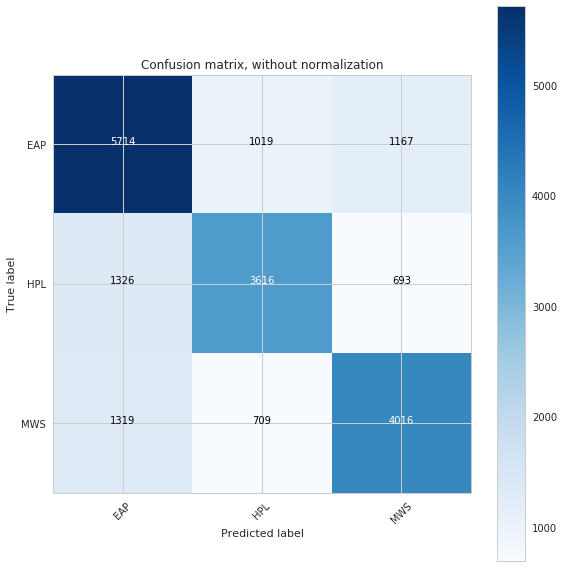

In [58]:
cnf_matrix = confusion_matrix(y_train, np.argmax(lr_oof_sve_train, axis=1))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## Second-Level Predictions from the First-level Output

### Checkpoint

In [59]:
train.to_pickle('train.pkl')
test.to_pickle('test.pkl')
#train = pd.read_pickle('train.pkl')
#test = pd.read_pickle('test.pkl')

train.head()

,id,text,author,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,...,mnb_oof_tfc_mws,rf_oof_tfc_eap,rf_oof_tfc_hpl,rf_oof_tfc_mws,lr_oof_sve_eap,lr_oof_sve_hpl,lr_oof_sve_mws,rf_oof_sve_eap,rf_oof_sve_hpl,rf_oof_sve_mws
0,id26305,"This process, however, afforded me no means of...",EAP,41,231,4.487805,35,20,7,2,...,0.000548,0.425655,0.292958,0.281387,0.750787,0.217372,0.031841,0.557489,0.236974,0.205537
1,id17569,It never once occurred to me that the fumbling...,HPL,14,71,4.071429,14,8,1,0,...,0.028803,0.414929,0.283338,0.301733,0.618704,0.368790,0.012506,0.458920,0.318258,0.222822
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,200,4.444444,32,17,5,0,...,0.000008,0.370884,0.350683,0.278433,0.585644,0.250258,0.164097,0.385273,0.329985,0.284742
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,206,4.970588,31,13,4,0,...,0.999813,0.310512,0.272094,0.417394,0.053616,0.195808,0.750576,0.261787,0.393867,0.344346
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,174,5.333333,25,11,4,0,...,0.013236,0.397471,0.307124,0.295404,0.208103,0.582494,0.209404,0.351915,0.411434,0.236651


In [60]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# load json and create model
json2_file = open('model2.json', 'r')
loaded_model2_json = json2_file.read()
json2_file.close()
loaded_model2 = model_from_json(loaded_model2_json)
loaded_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# load weights into new model
loaded_model2.load_weights("model2.h5")
print("Loaded model from disk")

Loaded model from disk
Loaded model from disk


In [66]:
#score = loaded_model.evaluate(xvalid_pad, yvalid, verbose=0)
#print('Test loss: {}'.format(score[0]))
#print('Test accuracy: {}'.format(score[1]))

lstm_train = loaded_model.predict(xtrain_pad, batch_size=256)
lstm_test = loaded_model.predict(xtest_pad, batch_size=256)

lstm_train[:10]

array([[ 0.51632798,  0.25286543,  0.23080659],
       [ 0.16239415,  0.30062905,  0.53697675],
       [ 0.53022891,  0.31512594,  0.15464525],
       [ 0.77481425,  0.1359192 ,  0.08926644],
       [ 0.13735546,  0.80081326,  0.0618312 ],
       [ 0.6158886 ,  0.25798211,  0.12612936],
       [ 0.2304244 ,  0.62313491,  0.14644065],
       [ 0.29038092,  0.4478209 ,  0.26179823],
       [ 0.414083  ,  0.5184567 ,  0.06746029],
       [ 0.52510774,  0.28421497,  0.1906773 ]], dtype=float32)

In [67]:
#score = loaded_model2.evaluate(xvalid_pad, yvalid, verbose=0)
#print('Test loss: {}'.format(score[0]))
#print('Test accuracy: {}'.format(score[1]))

gru_train = loaded_model2.predict(xtrain_pad, batch_size=256)
gru_test = loaded_model2.predict(xtest_pad, batch_size=256)

gru_train[:10]

array([[ 0.4468604 ,  0.27969381,  0.27344584],
       [ 0.13588952,  0.26042879,  0.60368162],
       [ 0.37065294,  0.43356717,  0.19577986],
       [ 0.64107227,  0.26480281,  0.09412484],
       [ 0.18414539,  0.69578528,  0.1200693 ],
       [ 0.56225026,  0.29033524,  0.14741449],
       [ 0.20580117,  0.65319759,  0.14100125],
       [ 0.25149843,  0.39366356,  0.35483807],
       [ 0.37336779,  0.53096133,  0.0956709 ],
       [ 0.42682225,  0.3303639 ,  0.24281389]], dtype=float32)

In [68]:
np.save('../model/lstm_train', lstm_train)
np.save('../model/gru_train', gru_train)

In [69]:
columns = ['lstm_eap', 'lstm_hpl', 'lstm_mws']
train = pd.concat([train, pd.DataFrame(lstm_train, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(lstm_test, columns=columns)], axis=1)

columns = ['gru_eap', 'gru_hpl', 'gru_mws']
train = pd.concat([train, pd.DataFrame(gru_train, columns=columns)], axis=1)
test = pd.concat([test, pd.DataFrame(gru_test, columns=columns)], axis=1)

### First-level output as new features

#### kfold method

In [70]:
# Prepare the data for modeling
drop_elements = ['id', 'text']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 310) (8392, 310)


,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,...,lr_oof_sve_mws,rf_oof_sve_eap,rf_oof_sve_hpl,rf_oof_sve_mws,lstm_eap,lstm_hpl,lstm_mws,gru_eap,gru_hpl,gru_mws
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,...,0.031841,0.557489,0.236974,0.205537,0.516328,0.252865,0.230807,0.446860,0.279694,0.273446
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,...,0.012506,0.458920,0.318258,0.222822,0.162394,0.300629,0.536977,0.135890,0.260429,0.603682
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,...,0.164097,0.385273,0.329985,0.284742,0.530229,0.315126,0.154645,0.370653,0.433567,0.195780
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,...,0.750576,0.261787,0.393867,0.344346,0.774814,0.135919,0.089266,0.641072,0.264803,0.094125
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,...,0.209404,0.351915,0.411434,0.236651,0.137355,0.800813,0.061831,0.184145,0.695785,0.120069


In [71]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
    break # important, only run once

#pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

[0]	train-mlogloss:0.996385	val-mlogloss:0.996348
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.284071	val-mlogloss:0.291256
[80]	train-mlogloss:0.238073	val-mlogloss:0.263476
[120]	train-mlogloss:0.210957	val-mlogloss:0.25764
[160]	train-mlogloss:0.189183	val-mlogloss:0.256193
[200]	train-mlogloss:0.171048	val-mlogloss:0.256312
[240]	train-mlogloss:0.155761	val-mlogloss:0.25674
Stopping. Best iteration:
[193]	train-mlogloss:0.174173	val-mlogloss:0.256018

Mean cv score: 0.25601755729207276


In [76]:
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171205-01-finetune.csv", index=False)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


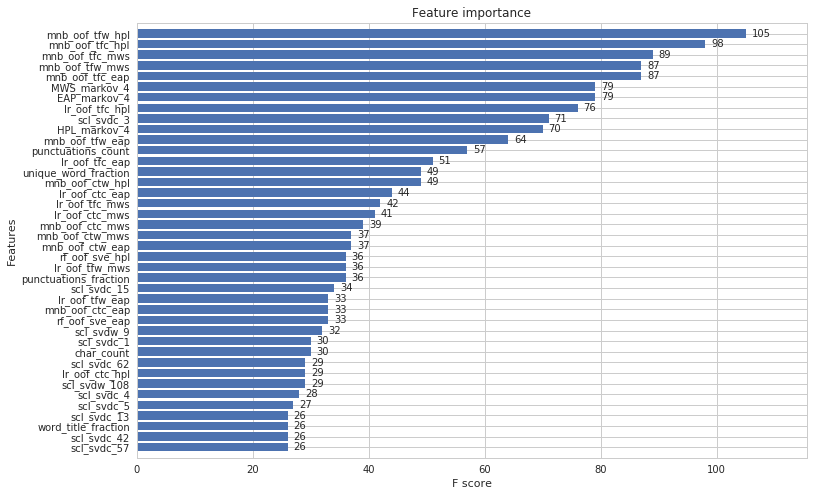

In [72]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:40]),
    ax=ax,
    height=0.8)
plt.show()

Confusion matrix, without normalization
[[1383   55   98]
 [  66 1066   36]
 [ 100   46 1066]]


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


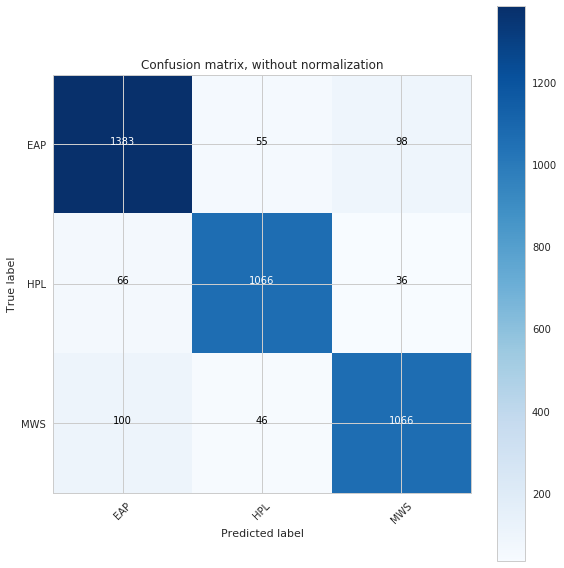

In [73]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

#### train_test_split method

In [74]:
xtrain, xval, ytrain, yval = model_selection.train_test_split(
    x_train, y_train, test_size=0.2, random_state=2017)
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dval = xgb.DMatrix(xval, label=yval)
dtest = xgb.DMatrix(x_test)
watchlist = [(dtrain, 'train'), (dval, 'valid')]

model_2 = xgb.train(
    xgb_param,
    dtrain,
    2000,
    watchlist,
    early_stopping_rounds=50,
    maximize=False,
    verbose_eval=40)

[0]	train-mlogloss:0.996191	valid-mlogloss:0.996177
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.284029	valid-mlogloss:0.29115
[80]	train-mlogloss:0.238496	valid-mlogloss:0.264136
[120]	train-mlogloss:0.211089	valid-mlogloss:0.258208
[160]	train-mlogloss:0.189827	valid-mlogloss:0.255727
[200]	train-mlogloss:0.171113	valid-mlogloss:0.256124
Stopping. Best iteration:
[160]	train-mlogloss:0.189827	valid-mlogloss:0.255727



In [77]:
pred_y_test = model_2.predict(dtest, ntree_limit=model_2.best_ntree_limit)

out_df = pd.DataFrame(pred_y_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171205-02-finetune.csv", index=False)

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


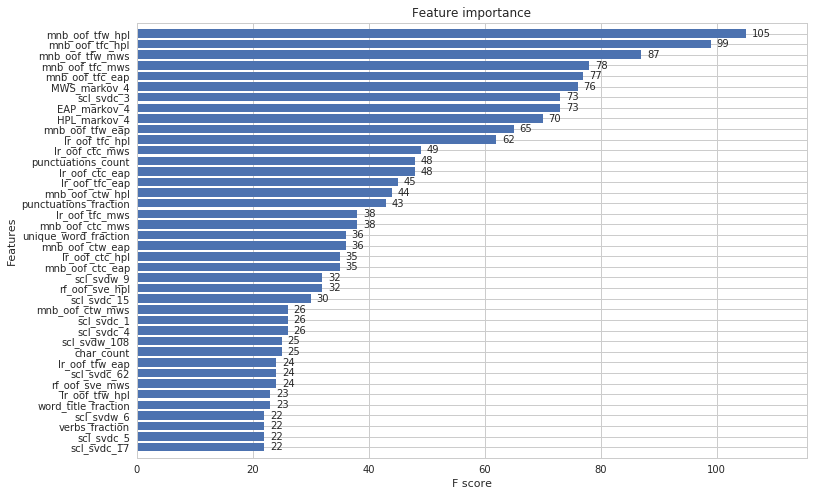

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model_2.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:40]),
    ax=ax,
    height=0.8)
plt.show()

# Feature Engineering

## Naive Bayes model using Text based features

In [79]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

Mean cv score: 1.039853560846631


## lda TODO

In [60]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = ("\nTopic #{}: ").format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [61]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)

lda.fit(tf_train)


n_top_words = 20
print("Topics in LDA model: ")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)


first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]

first_topic.shape


first_topic_words = [
    tfidf_feature_names[i] for i in first_topic.argsort()[:-50 - 1:-1]
]
second_topic_words = [
    tfidf_feature_names[i] for i in second_topic.argsort()[:-50 - 1:-1]
]
third_topic_words = [
    tfidf_feature_names[i] for i in third_topic.argsort()[:-50 - 1:-1]
]

Topics in LDA model: 

Topic #0: long think appeared subject time die peculiar escape regard public miserable duty law health ye mentioned vague evidently hope moment

Topic #1: eye hand hour moment came left time fear far water face moon general saw turned lay longer large foot away

Topic #2: love beauty secret sun thought shore silent wind act mountain music long cloud covered sea rich reality heart sky native

Topic #3: child sleep street perdita saw home imagination cast lord tomb window threw enemy house early vain ancient melancholy progress raymond

Topic #4: shall eye began raymond adrian expression head hand cottage later terrible lovely yes feel deep changed answer limb grave frame

Topic #5: man day night life like old word great did year dream father said body little time thing come light friend

Topic #6: thing said good let sound certain heard felt know say thought character did world matter present old kind nature earth

Topic #7: wide opinion say burst fly captain view